In [1]:
import random

# plotting the data
import matplotlib.pyplot as plt
import numpy as np
# used for the dataframes
import pandas as pd
from pandas import DataFrame
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

from gpu_dataloader import ForecastDataset, UtilizationDataset
from lstm_models import LSTM
from utils import get_device

from utils import get_device, get_device_as_string


/Users/macbook/opt/miniconda3/envs/ml_pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_path: str = f'models/epochs-3-Thu Oct 27 17:50:58 2022'
model_dict: dict = torch.load(f'{model_path}')

In [3]:
device = get_device()

In [4]:
model_dict.keys()

dict_keys(['epoch', 'learning_rate', 'input_size', 'hidden_size', 'num_layers', 'num_classes', 'seq_length', 'model_state_dict', 'optimizer_state_dict'])

In [5]:
input_size: int = model_dict['input_size']
hidden_size: int = model_dict['hidden_size']
num_layers: int = model_dict['num_layers']
num_classes: int = model_dict['num_classes']
seq_length: int = model_dict['seq_length']

In [6]:
model = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length).to(device)
model.load_state_dict(model_dict['model_state_dict'])

<All keys matched successfully>

In [7]:
batch_size: int = 1000
training_dataset = UtilizationDataset(small_df=True, batch_size=batch_size)

## Evaluate Model with Training Data

In [8]:
feature_df = training_dataset.X.to(device)
training_prediction = model(feature_df)

In [9]:
feature_df = training_dataset.X_scaler.convert_tensor_to_df(feature_df)

In [10]:
actual_data = training_dataset.y.data.numpy()
label_columns = training_dataset._get_label_columns()

### Move from GPU to CPU if necessary and convert to Numpy array

In [11]:
if torch.has_cuda or torch.has_mps:
    prediction = training_prediction.cpu().detach().numpy()
else:
    prediction = training_prediction.data.numpy()

In [12]:
PLAN_CPU_COLUMN: str = 'plan_cpu'
PLAN_MEM_COLUMN: str = 'plan_mem'
ACTUAL_CPU_COLUMN: str = 'actual cpu usage'
ACTUAL_MEM_COLUMN: str = 'actual mem usage'
PREDICTED_CPU_COLUMN: str = 'predicted cpu usage'
PREDICTED_MEM_COLUMN: str = 'predicted mem usage'

In [13]:
def get_plan_df() -> DataFrame:
    plan_df = training_dataset.X_scaler.inverse_standardize_df(feature_df)
    plan_df = plan_df[[PLAN_CPU_COLUMN, PLAN_MEM_COLUMN]]
    return plan_df

In [14]:
def get_combined_df(actual_data_df: DataFrame, prediction_df: DataFrame) -> DataFrame:
    actual_df = training_dataset.y_scaler.inverse_normalization_df(actual_data_df)
    predict_df = training_dataset.y_scaler.inverse_normalization_df(prediction_df)
    
    combined_df = pd.merge(actual_df, predict_df, left_index=True, right_index=True)
    combined_df[[PLAN_CPU_COLUMN, PLAN_MEM_COLUMN]] = get_plan_df()
    combined_df.rename(columns={'cpu_usage_x': ACTUAL_CPU_COLUMN, 'cpu_usage_y': PREDICTED_CPU_COLUMN, 'avg_mem_x': ACTUAL_MEM_COLUMN, 'avg_mem_y': PREDICTED_MEM_COLUMN}, inplace=True)

    return combined_df

### Convert to DataFrames

In [15]:
# create dataframes
training_prediction_df = pd.DataFrame(prediction, columns=label_columns)
training_actual_data_df = pd.DataFrame(actual_data, columns=label_columns)

combined_df = get_combined_df(training_actual_data_df, training_prediction_df)

In [16]:
cycler = plt.cycler(linestyle=['-', '-.', '--', '-', '--', '-', '--'],
                    color=['green', 'blue', 'orange', 'orange', 'orange', 'green', 'green'],
)

def plot_df(df: DataFrame, df_columns: list, start_range: int = -1, end_range: int = -1, save_plot_path: str = None):  # type: ignore
    if start_range == -1:
        start_range = 0
    if end_range == -1:
        end_range = len(df)
    fig, ax = plt.subplots()
    ax.set_prop_cycle(cycler)
    plot = df[df_columns].iloc[start_range:end_range].plot.line(figsize=(30, 20), linewidth=3, ax=ax)
    if save_plot_path is not None:
        plot.figure.savefig(save_plot_path)

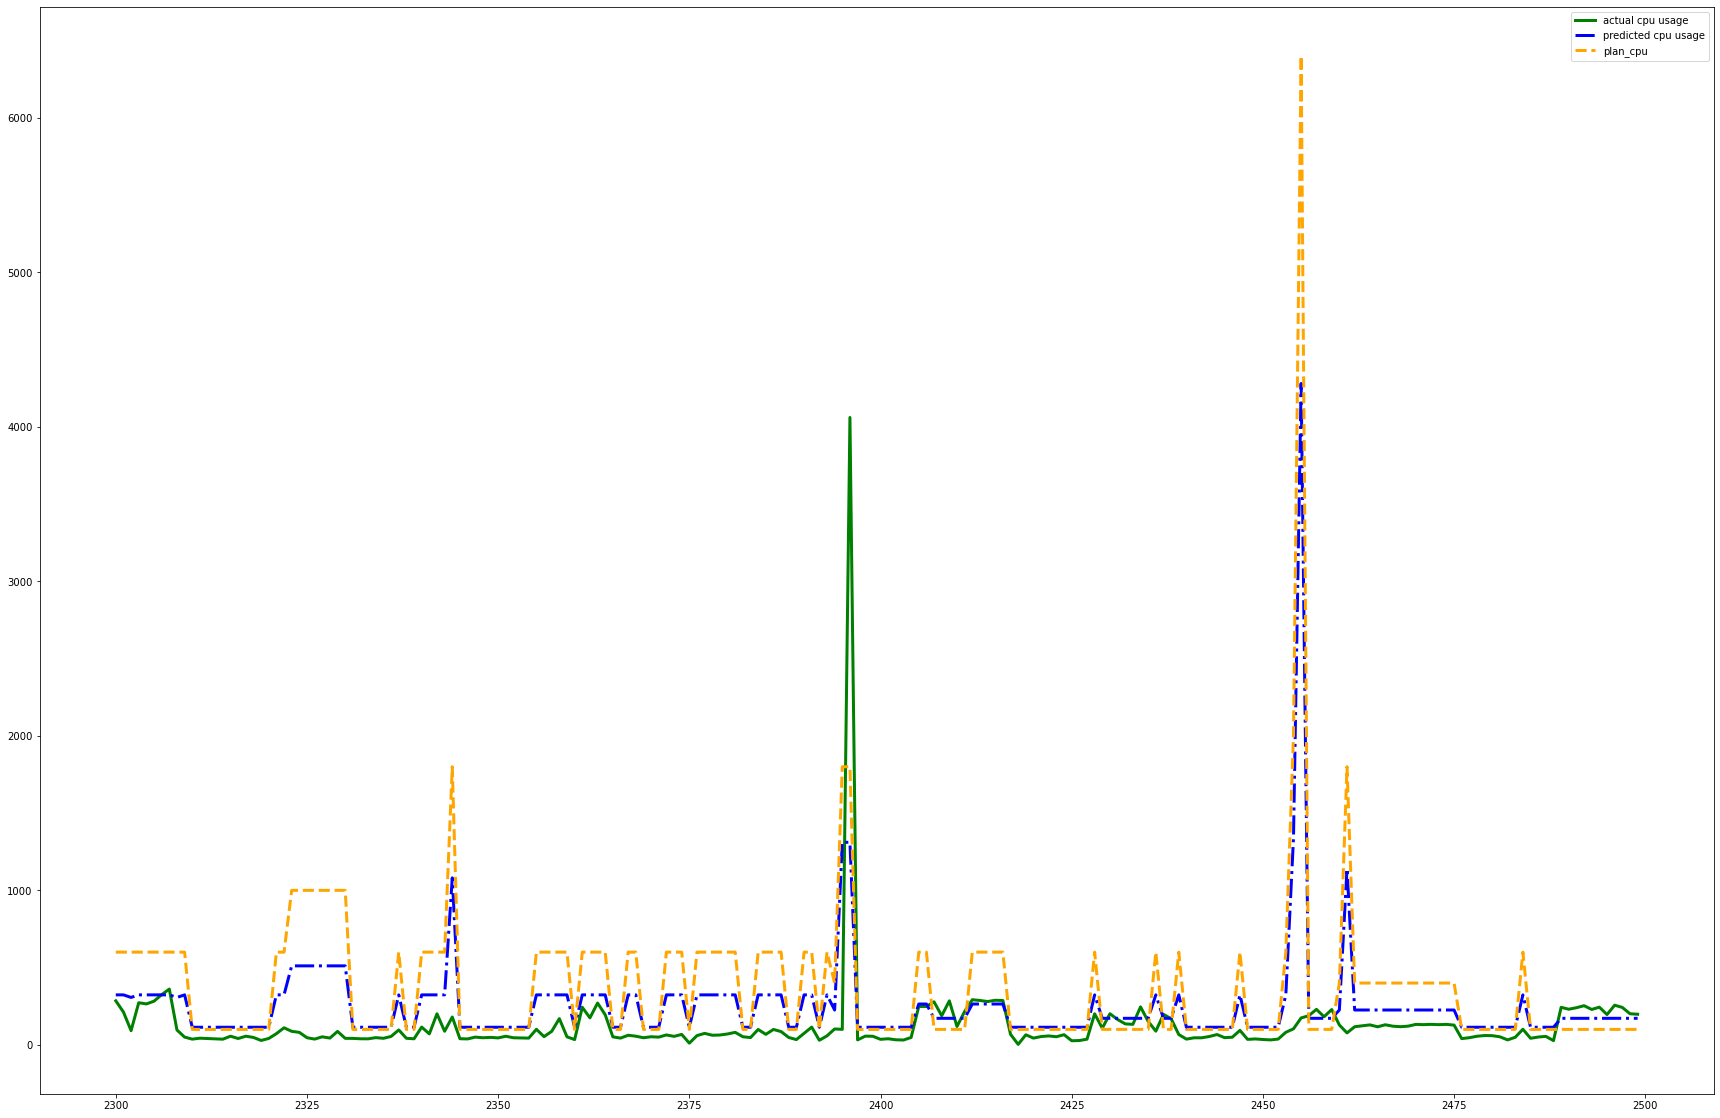

In [17]:
# combined_df[[ACTUAL_CPU_COLUMN, PREDICTED_CPU_COLUMN]].plot.line(figsize=(30, 25))
plot_df(combined_df, [ACTUAL_CPU_COLUMN, PREDICTED_CPU_COLUMN, PLAN_CPU_COLUMN], 2300, 2500)

- Time Range, how well is the accuracy for a certain time window
- Inference Time for different ranges
- Evaluation Scenario for different data sizes
- Standardization vs not standardization (also batchnorm)
- Compare sklearn StandardScaler vs DataFrameScaler
- Including Categorization Data like task type
- Make bar graph of utilization wastage

In [18]:
test_dataset = UtilizationDataset(is_training=False, small_df=True, batch_size=batch_size)

In [19]:
test_feature_df = test_dataset.X.to(device)

In [20]:
test_prediction = model(test_feature_df)

In [21]:
test_feature_df = test_dataset.X_scaler.convert_tensor_to_df(test_feature_df)
test_actual_data = test_dataset.y.data.numpy()

In [24]:
if torch.has_cuda or torch.has_mps:
    test_prediction = test_prediction.cpu().detach().numpy()
else:
    test_prediction = test_prediction.data.numpy()

In [25]:
test_prediction_df = pd.DataFrame(test_prediction, columns=label_columns)
test_actual_df = pd.DataFrame(test_actual_data, columns=label_columns)

test_combined_df = get_combined_df(test_actual_df, test_prediction_df)

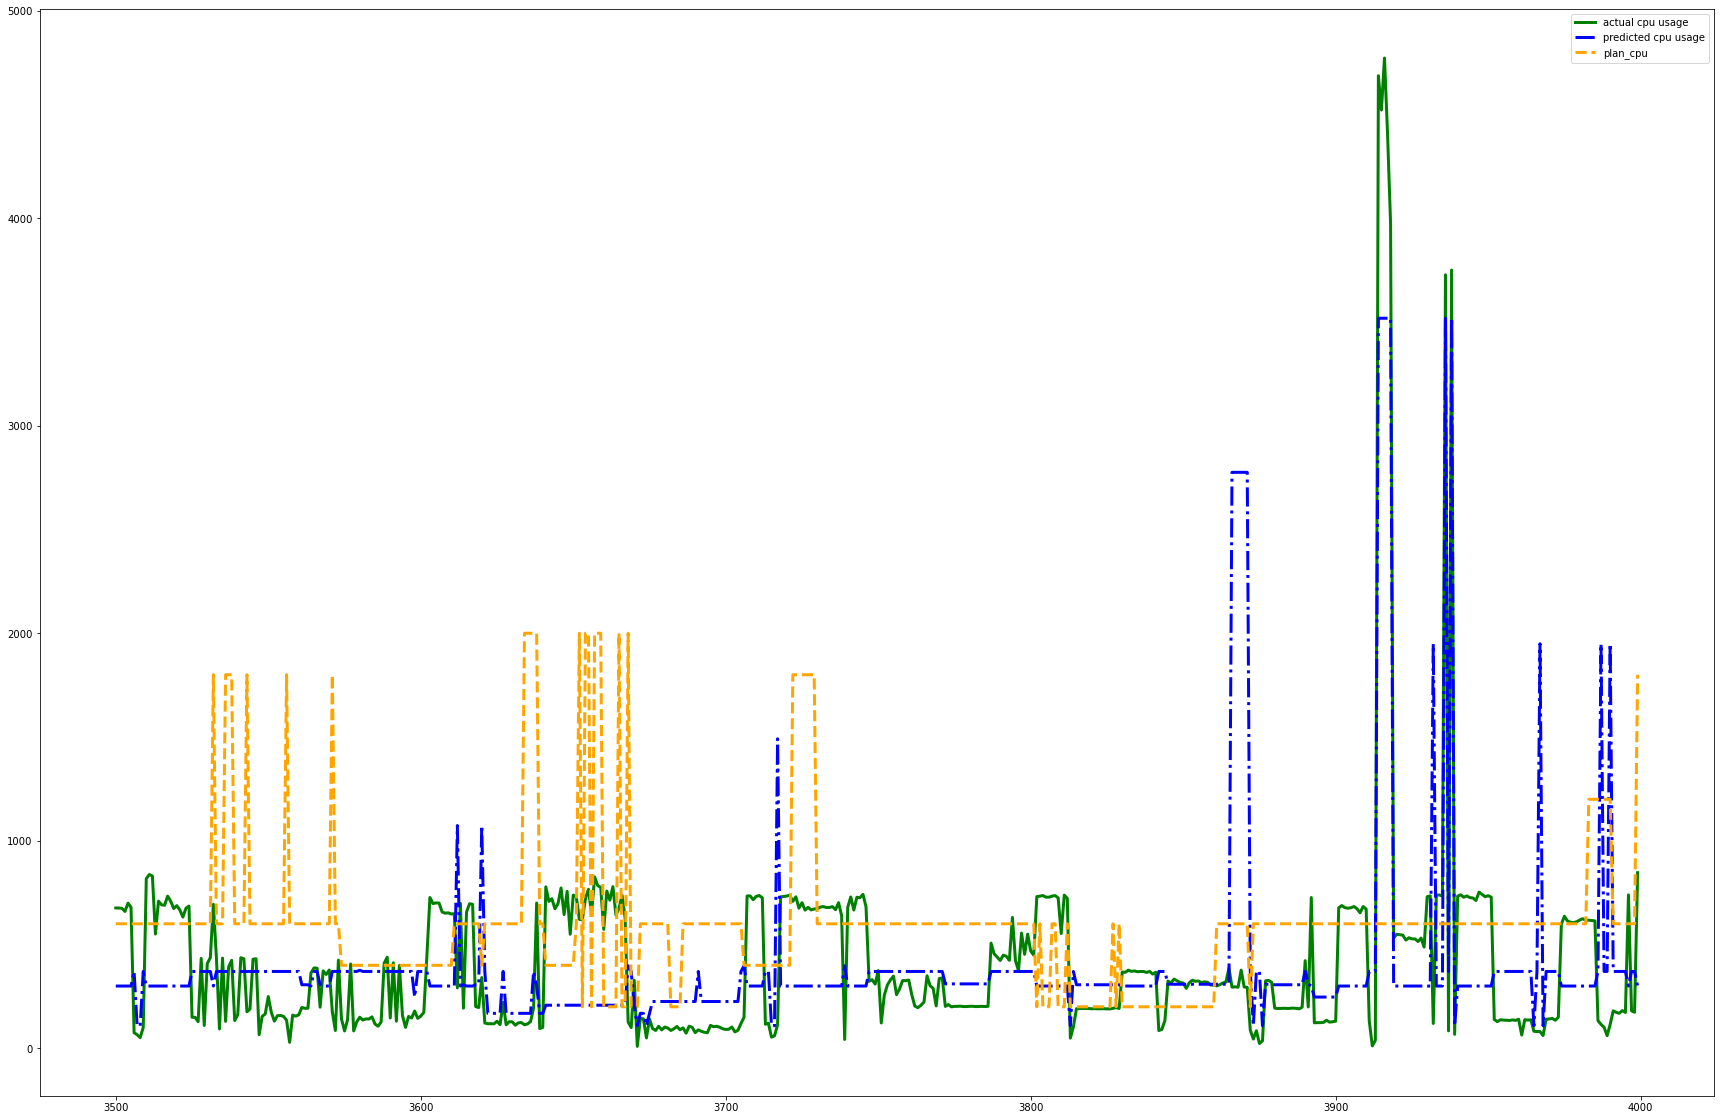

In [28]:
plot_df(test_combined_df, [ACTUAL_CPU_COLUMN, PREDICTED_CPU_COLUMN, PLAN_CPU_COLUMN], 3500, 4000)